In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os,shutil

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2024-08-12 03:34:49.885531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 03:34:49.885659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 03:34:50.020814: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Define the function to get data
def get_data(data_dir):
    labels = ['PNEUMONIA', 'NORMAL']  # Define labels within the function
    img_size = 150  # Define the image size
    data = []
    targets = []
    
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        if not os.path.exists(path):
            print(f"Directory {path} does not exist. Skipping.")
            continue
            
        images_found = False 
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Failed to read image: {img_path}")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                data.append(resized_arr)
                targets.append(class_num)
                images_found=True
            except Exception as e:
                print(f"Error loading image {img}: {e}")
                
        if not images_found:
            print(f"No images found for label {label} in directory {path}.")
    
    if not data:
        print("No data loaded. Please check your file paths.")
    return np.array(data), np.array(targets)


Data Loading

In [5]:
train_features, train_labels = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/train")
test_features, test_labels = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/test")
val_features, val_labels = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/val")

In [7]:
def get_image_shapes_from_directory(directory, target_size=(150, 150)):
    shapes = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        try:
            image = Image.open(img_path).convert('RGB')  # Convert all images to RGB
            image = image.resize(target_size)
            image_array = np.array(image)
            shapes.append(image_array.shape)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return shapes

pneumonia_train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"
normal_train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"
pneumonia_val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA"
normal_val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL"

pneumonia_train_shapes = get_image_shapes_from_directory(pneumonia_train_dir)
normal_train_shapes = get_image_shapes_from_directory(normal_train_dir)
pneumonia_val_shapes = get_image_shapes_from_directory(pneumonia_val_dir)
normal_val_shapes = get_image_shapes_from_directory(normal_val_dir)

# Print shapes
print("Pneumonia Train Shapes Sample:", pneumonia_train_shapes[:5])  # Show a sample of shapes
print("Normal Train Shapes Sample:", normal_train_shapes[:5])  # Show a sample of shapes
print("Pneumonia Validation Shapes Sample:", pneumonia_val_shapes[:5])  # Show a sample of shapes
print("Normal Validation Shapes Sample:", normal_val_shapes[:5])  # Show a sample of shapes

# Get total counts
print("Pneumonia Train Count:", len(pneumonia_train_shapes))
print("Normal Train Count:", len(normal_train_shapes))
print("Pneumonia Validation Count:", len(pneumonia_val_shapes))
print("Normal Validation Count:", len(normal_val_shapes))

Pneumonia Train Shapes Sample: [(150, 150, 3), (150, 150, 3), (150, 150, 3), (150, 150, 3), (150, 150, 3)]
Normal Train Shapes Sample: [(150, 150, 3), (150, 150, 3), (150, 150, 3), (150, 150, 3), (150, 150, 3)]
Pneumonia Validation Shapes Sample: [(150, 150, 3), (150, 150, 3), (150, 150, 3), (150, 150, 3), (150, 150, 3)]
Normal Validation Shapes Sample: [(150, 150, 3), (150, 150, 3), (150, 150, 3), (150, 150, 3), (150, 150, 3)]
Pneumonia Train Count: 3875
Normal Train Count: 1341
Pneumonia Validation Count: 8
Normal Validation Count: 8


In [6]:
import numpy as np

# Function to count class occurrences
def count_classes(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

# Count the number of samples per class
train_class_counts = count_classes(train_labels)
test_class_counts = count_classes(test_labels)
val_class_counts = count_classes(val_labels)

print("Training Data Class Counts:", train_class_counts)
print("Test Data Class Counts:", test_class_counts)
print("Validation Data Class Counts:", val_class_counts)


Training Data Class Counts: {0: 3875, 1: 1341}
Test Data Class Counts: {0: 390, 1: 234}
Validation Data Class Counts: {0: 8, 1: 8}


In [7]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: 0.6730322580645162, 1: 1.9448173005219984}


Data Visualization

In [8]:
normal = os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL")
normal_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"

In [9]:
pneumonia = os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

In [10]:
validation = os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL")
normal_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"

In [11]:
# Function to compute the average image
def compute_average_image(image_dir, image_list, img_size=(150, 150)):
    avg_image = None
    num_images = len(image_list)
    
    for image_name in image_list:
        img_path = os.path.join(image_dir, image_name)
        img = plt.imread(img_path)
        if img.ndim == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, img_size).astype(np.float32)
        
        if avg_image is None:
            avg_image = img
        else:
            avg_image += img
    
    avg_image /= num_images
    return avg_image

In [12]:
# Lists of image file names
pneumonia_images = os.listdir(pneumonia_dir)
normal_images = os.listdir(normal_dir)

In [13]:
# Compute average images
avg_normal = compute_average_image(normal_dir, normal_images[:100])  # Use first 100 images for speed
avg_pneumonia = compute_average_image(pneumonia_dir, pneumonia_images[:100])

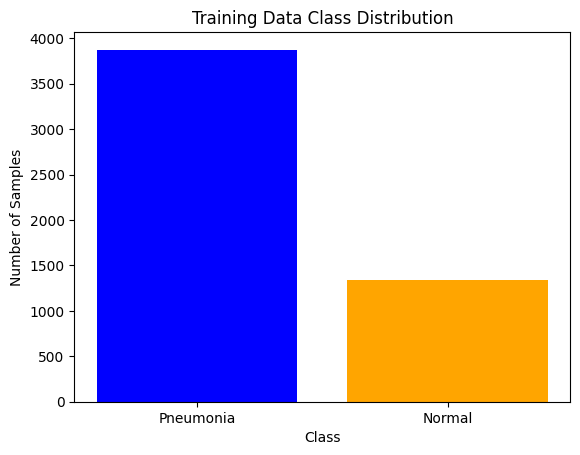

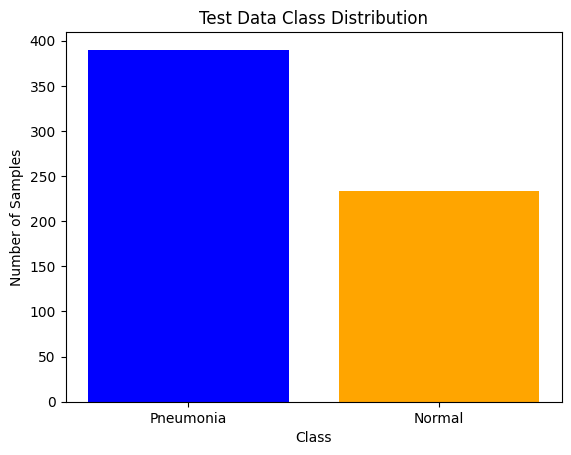

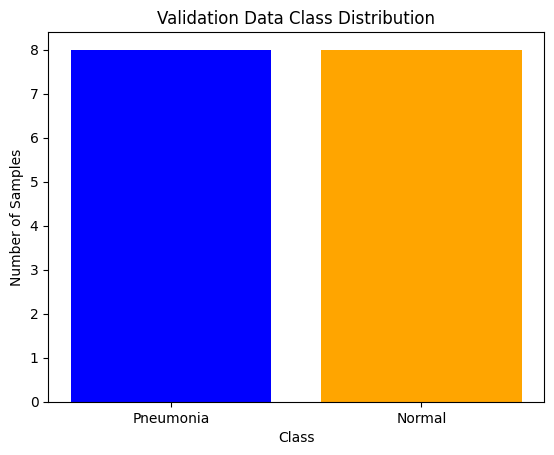

In [14]:
import matplotlib.pyplot as plt

# Plot class distribution for training data
train_class_counts = count_classes(train_labels)
plt.bar(train_class_counts.keys(), train_class_counts.values(), color=['blue', 'orange'])
plt.xticks([0, 1], ['Pneumonia', 'Normal'])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Training Data Class Distribution')
plt.show()

# Plot class distribution for test data
test_class_counts = count_classes(test_labels)
plt.bar(test_class_counts.keys(), test_class_counts.values(), color=['blue', 'orange'])
plt.xticks([0, 1], ['Pneumonia', 'Normal'])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Test Data Class Distribution')
plt.show()

# Plot class distribution for validation data
val_class_counts = count_classes(val_labels)
plt.bar(val_class_counts.keys(), val_class_counts.values(), color=['blue', 'orange'])
plt.xticks([0, 1], ['Pneumonia', 'Normal'])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Validation Data Class Distribution')
plt.show()


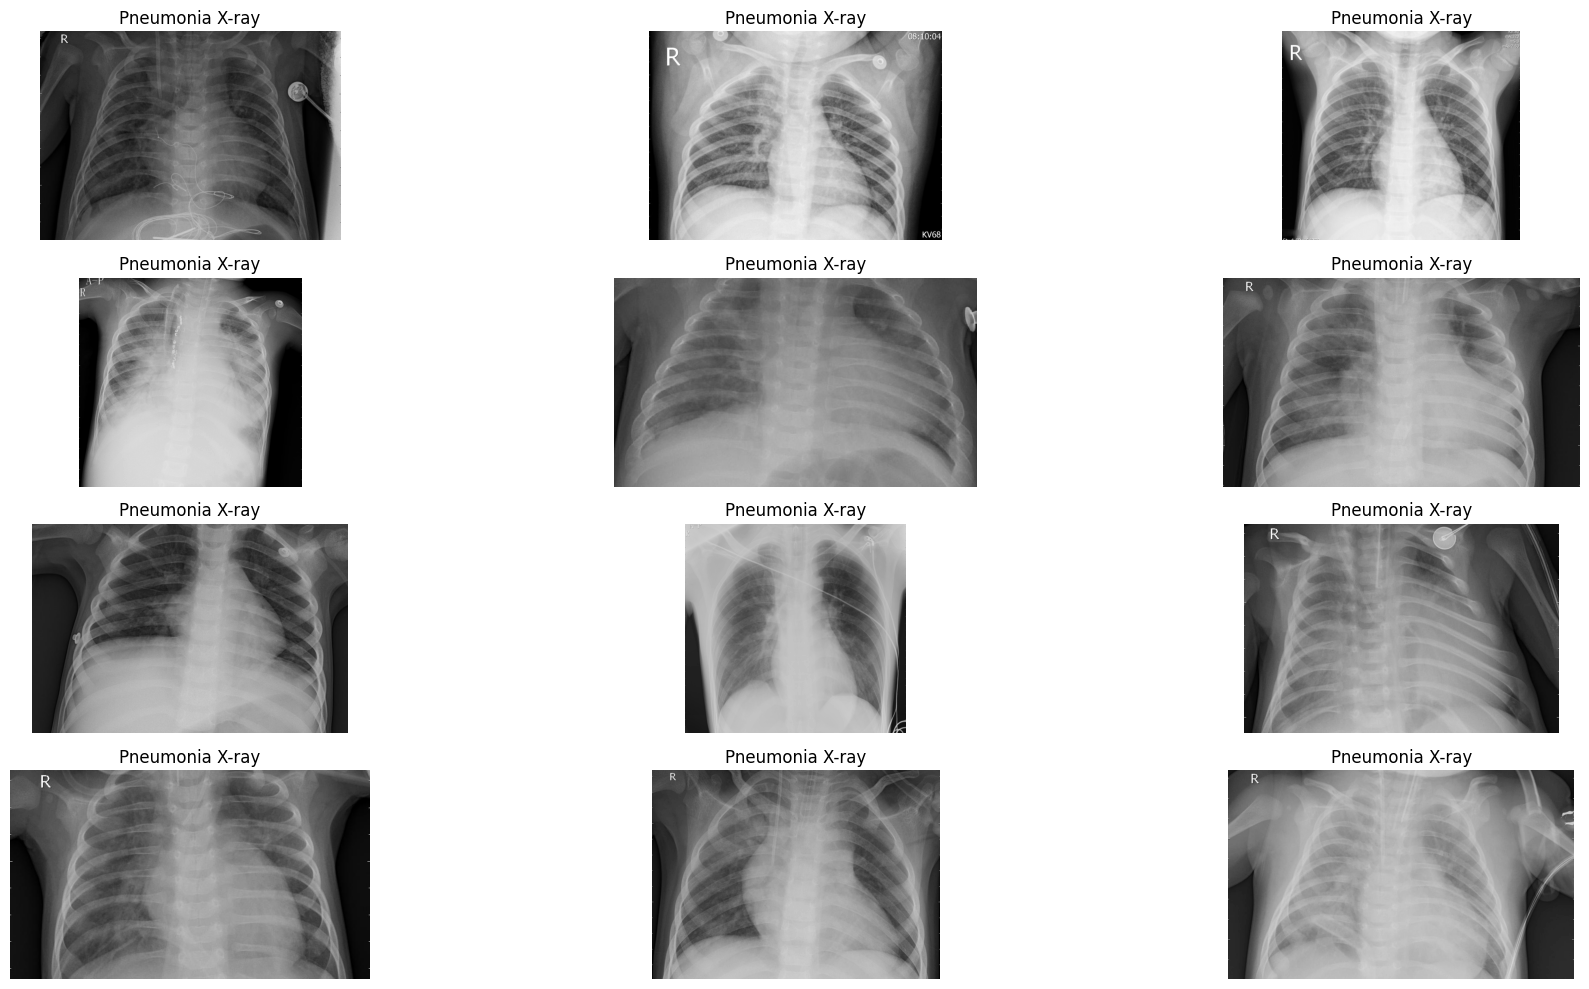

In [15]:

plt.figure(figsize=(20,10))

for i in range(12):
    plt.subplot(4,3, i+1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()
plt.show()

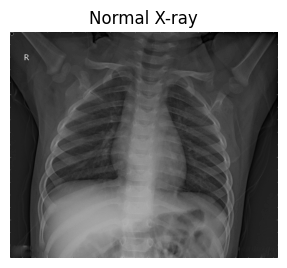

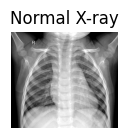

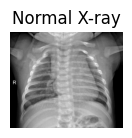

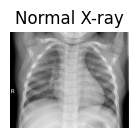

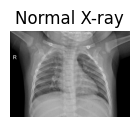

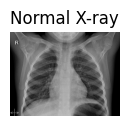

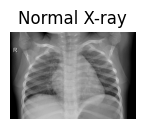

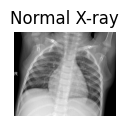

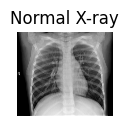

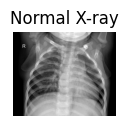

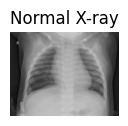

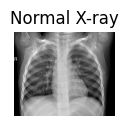

In [19]:
plt.figure(figsize=(20,10))

for i in range (12):
    plt.subplot(4,4,i+1)
    img=plt.imread(os.path.join(normal_dir,normal[i]))
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.title('Normal X-ray')
    plt.tight_layout()
    plt.show()
    

(-0.5, 149.5, 149.5, -0.5)

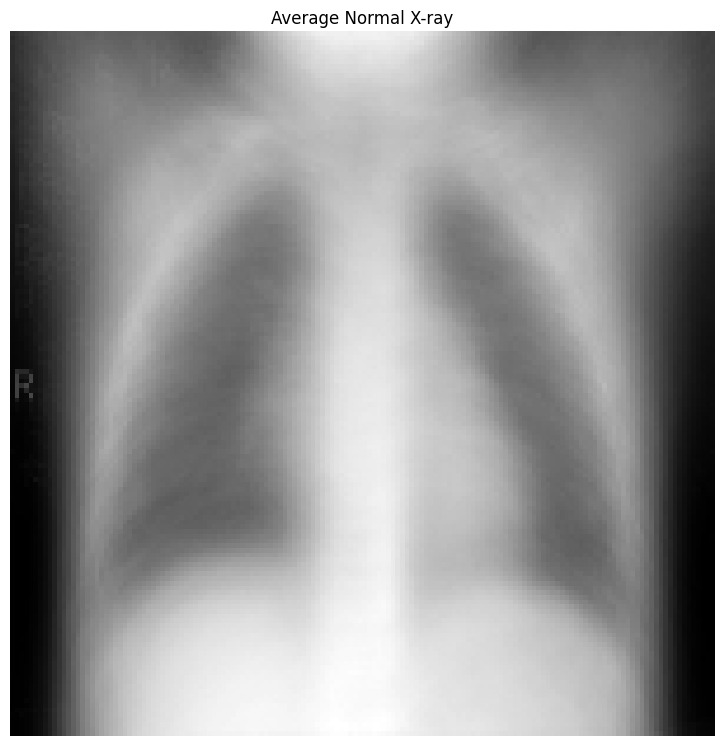

In [16]:
# Display heatmaps of average images
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(avg_normal, cmap='gray')
plt.title('Average Normal X-ray')
plt.axis('off')

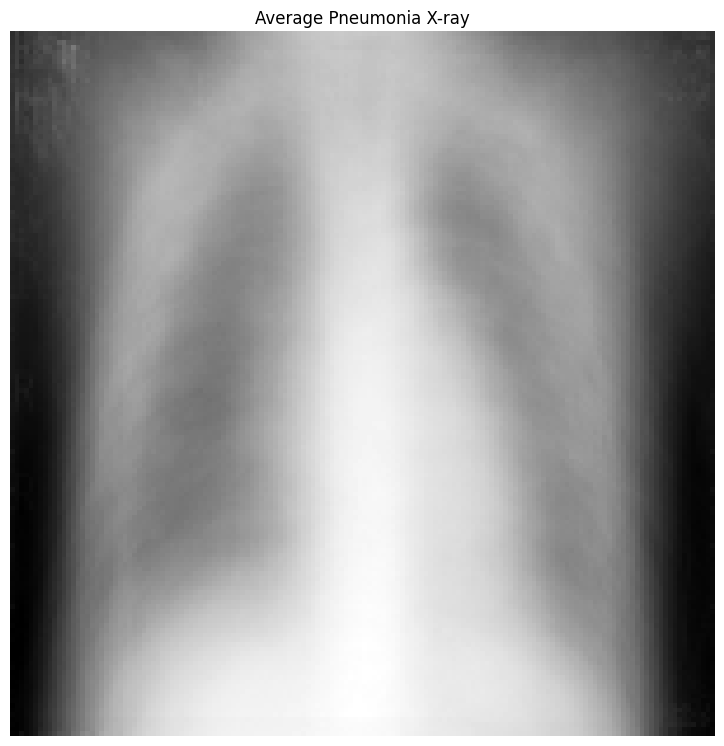

In [17]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 2)
plt.imshow(avg_pneumonia, cmap='gray')
plt.title('Average Pneumonia X-ray')
plt.axis('off')
plt.show()

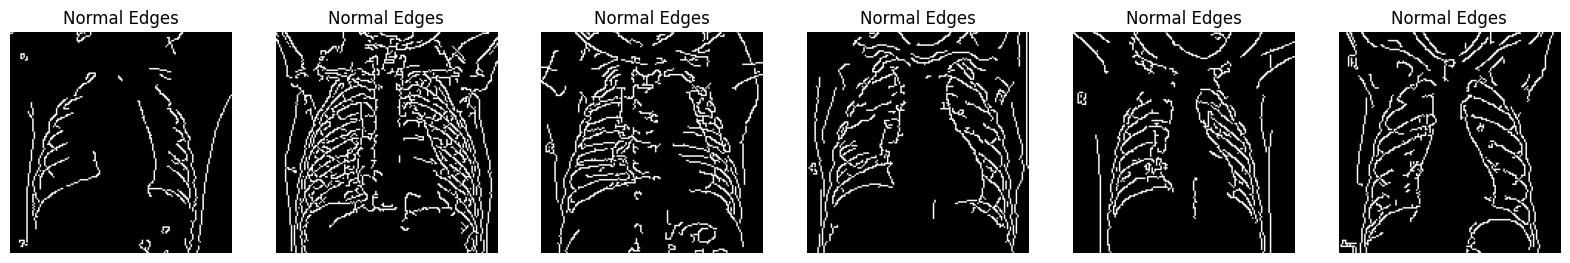

In [18]:
plt.figure(figsize=(20, 10))
for i in range(6):
    plt.subplot(2, 6, i+1)
    img = plt.imread(os.path.join(normal_dir, normal_images[i]))
    img = cv2.resize(img, (150, 150))
    edges = cv2.Canny(img, 100, 200)
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    plt.title('Normal Edges')

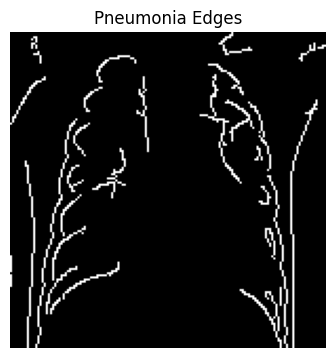

In [19]:
plt.figure(figsize=(20, 10))  
for i in range(6):
    plt.subplot(2, 6, i+1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia_images[i]))
    img = cv2.resize(img, (150, 150))
    edges = cv2.Canny(img, 100, 200)
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    plt.title('Pneumonia Edges')
    plt.tight_layout()
    plt.show()

Text(0, 0.5, 'Frequency')

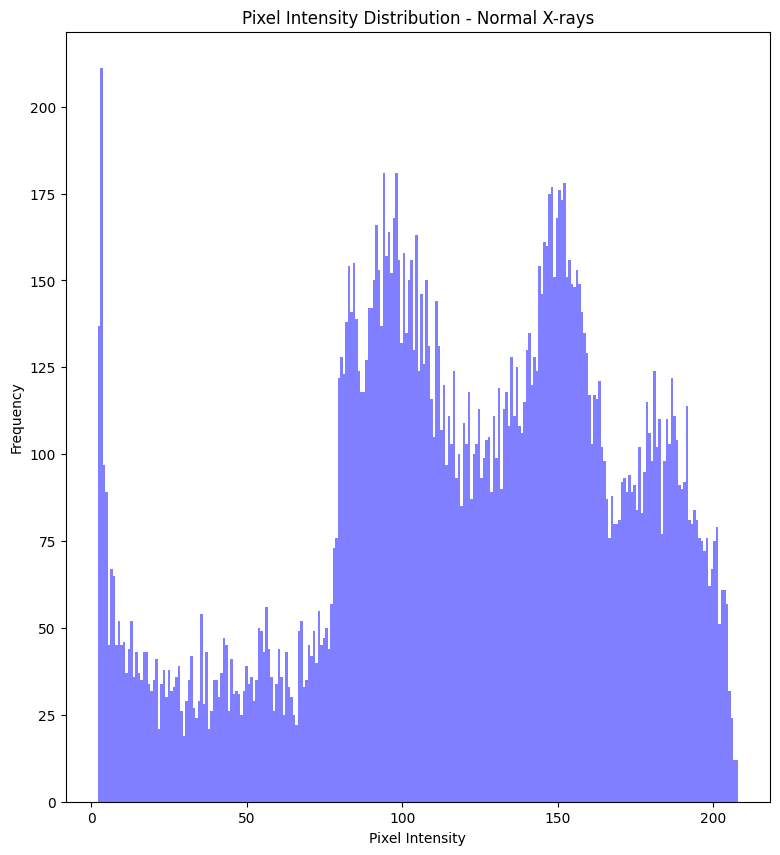

In [20]:
plt.figure(figsize=(20, 10))

# Normal X-rays Histogram
plt.subplot(1, 2, 1)
plt.hist(avg_normal.ravel(), bins=256, color='blue', alpha=0.5)
plt.title('Pixel Intensity Distribution - Normal X-rays')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

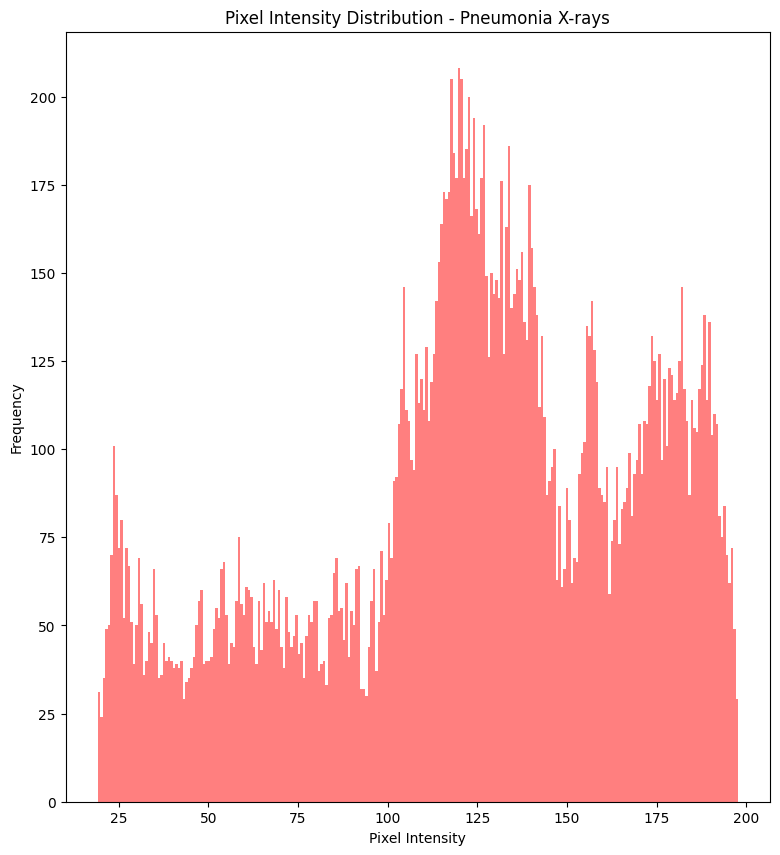

In [20]:
plt.figure(figsize=(20, 10))
# Pneumonia X-rays Histogram
plt.subplot(1, 2, 1)
plt.hist(avg_pneumonia.ravel(), bins=256, color='red', alpha=0.5)
plt.title('Pixel Intensity Distribution - Pneumonia X-rays')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.show()

(0.0, 149.0, 0.0, 149.0)

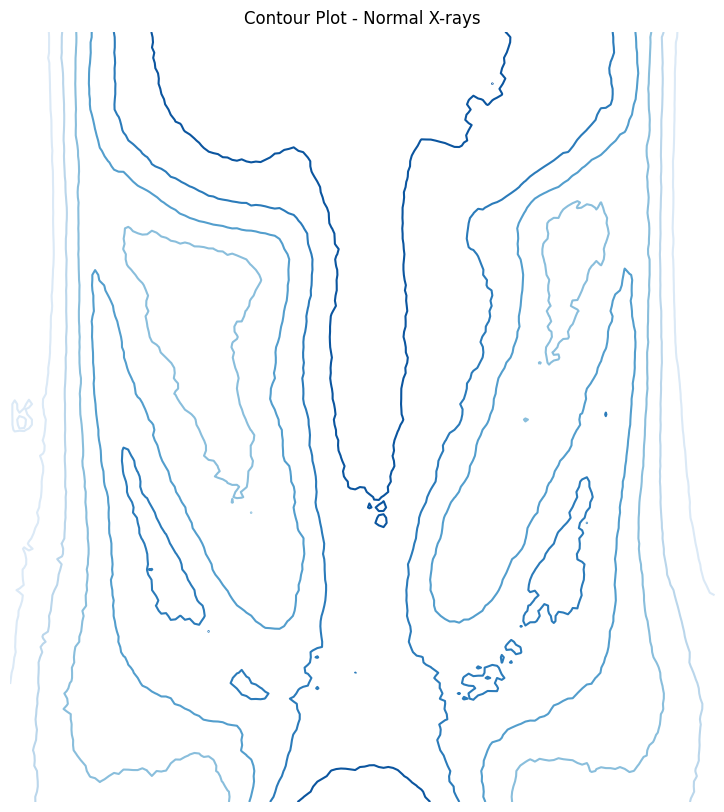

In [22]:
plt.figure(figsize=(20, 10))

# Normal X-rays Contour
plt.subplot(1, 2, 1)
plt.contour(avg_normal, cmap='Blues')
plt.title('Contour Plot - Normal X-rays')
plt.axis('off')

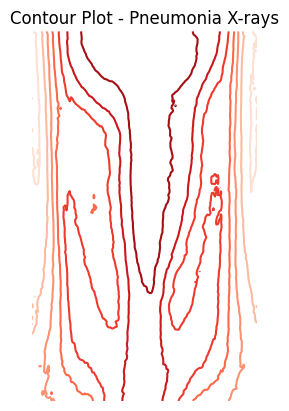

In [23]:
# Pneumonia X-rays Contour
plt.subplot(1, 2, 2)
plt.contour(avg_pneumonia, cmap='Reds')
plt.title('Contour Plot - Pneumonia X-rays')
plt.axis('off')

plt.show()

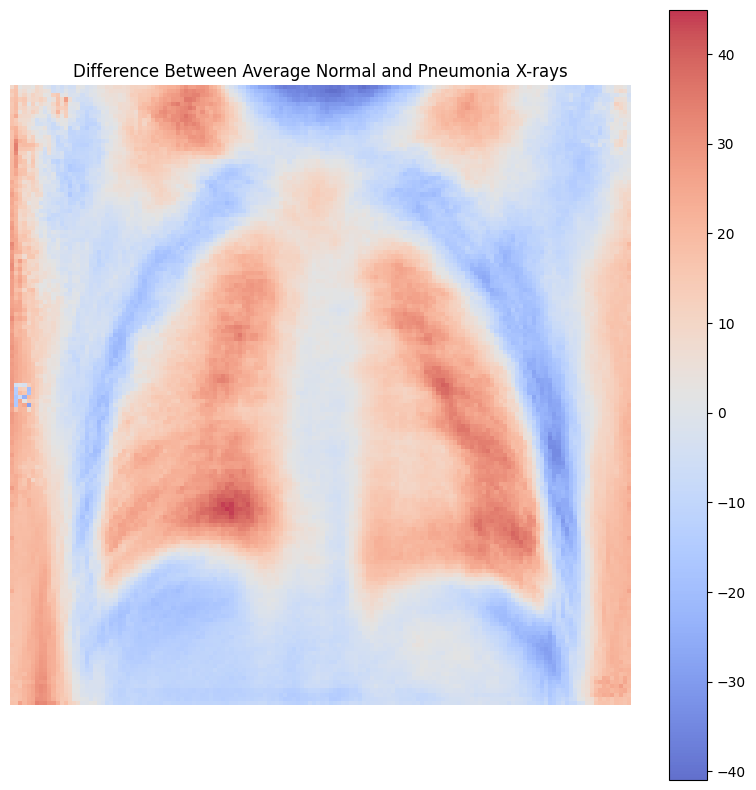

In [24]:
difference = avg_pneumonia - avg_normal

plt.figure(figsize=(10, 10))
plt.imshow(difference, cmap='coolwarm', alpha=0.8)
plt.colorbar()
plt.title('Difference Between Average Normal and Pneumonia X-rays')
plt.axis('off')
plt.show()

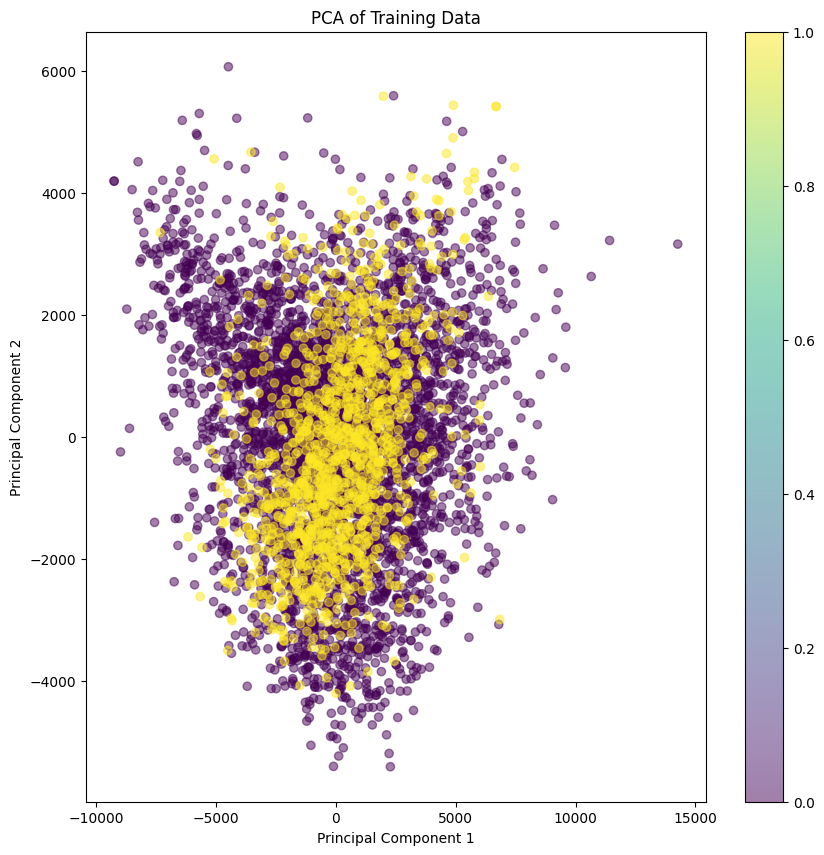

In [25]:
from sklearn.decomposition import PCA
# Flatten the images
train_features_flat = train_features.reshape(train_features.shape[0], -1)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train_features_flat)

plt.figure(figsize=(10, 10))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=train_labels, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('PCA of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [26]:
train_labels

array([0, 0, 0, ..., 1, 1, 1])

In [27]:
train_datagen = ImageDataGenerator(
                 rescale = 1. / 255, 
                  horizontal_flip=True,
                  rotation_range=20,
                  shear_range=0.2,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  zoom_range=0.2,
                  brightness_range=[0.8,1.2],
                  fill_mode="nearest",
                                         )

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [28]:
train_generator = train_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/train",
                                 batch_size = 32,
                                 target_size=(150,150),
                                 class_mode = 'binary',
                                 color_mode = 'rgb'
                                                   )
valid_generator = valid_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(150,150),
                                 class_mode = 'binary',
                                 color_mode = 'rgb'  
                                                   )
test_generator = test_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/test",
                                 batch_size = 32,
                                 target_size=(150,150),
                                 class_mode = 'binary',
                                 color_mode = 'rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [29]:
# Define paths
weights_url_vgg19 = 'https://storage.googleapis.com/tensorflow/keras-applications/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
local_weight_vgg19 = '/kaggle/input/vg19-h5/vgg19_weights.h5'
local_weights_path_inceptionv3 = '/kaggle/input/inception-v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [32]:

# Model 1: VGG19
base_model_vgg19 = VGG19(input_shape=(150, 150, 3), include_top=False, weights=None)
base_model_vgg19.load_weights('/kaggle/input/vg19-h5/vgg19_weights.h5')
base_model_vgg19.trainable = False

# Create a new Sequential model
model_vgg19 = Sequential([
    base_model_vgg19,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_vgg19.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Callbacks
callbacks = [
    ModelCheckpoint("best_model_vgg19.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
]

# Fine-tune some layers of VGG19
for layer in base_model_vgg19.layers:
    layer.trainable = True

# Train the model
history_vgg19 = model_vgg19.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=valid_generator.samples // 32,
    callbacks=callbacks
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.6899 - loss: 1.5889
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model_vgg19.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 461ms/step - accuracy: 0.6902 - loss: 1.5842 - val_accuracy: 0.5000 - val_loss: 0.7290 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.7290 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7500 - loss: 0.5800
Epoch 3: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 431ms/step - accuracy: 0.7500 - loss: 0.5799 - val_accuracy: 0.5000 - val_loss: 0.8167 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 

In [33]:
# Evaluate on validation set
val_loss, val_accuracy = model_vgg19.evaluate(valid_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5000 - loss: 0.7290
Validation Loss: 0.7290406823158264
Validation Accuracy: 0.5


In [34]:
# Generate classification report and confusion matrix
y_pred = model_vgg19.predict(test_generator)
y_pred_classes = y_pred > 0.5  # Assuming binary classification
y_true = test_generator.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



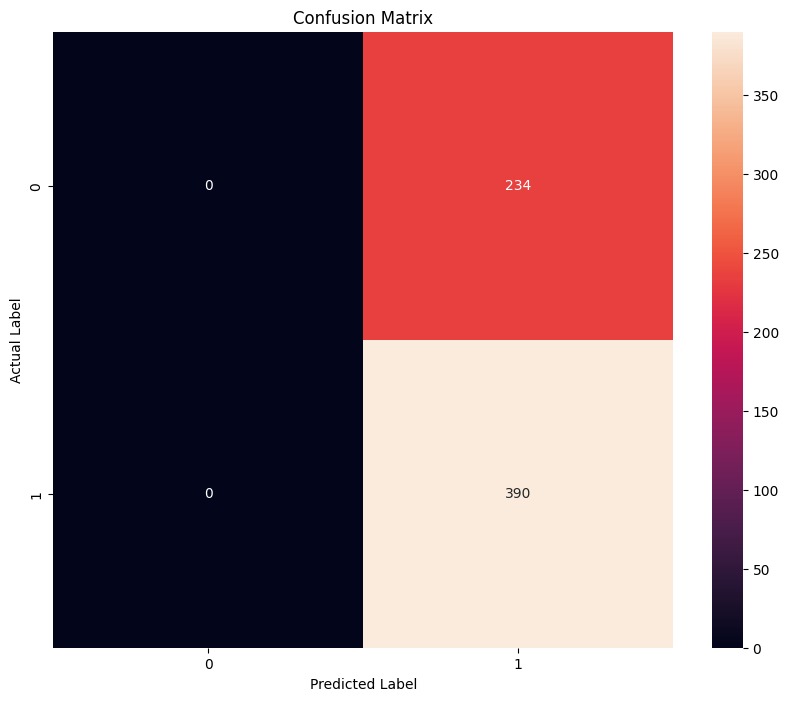

In [35]:

print(classification_report(y_true, y_pred_classes.astype(int)))
cm = confusion_matrix(y_true, y_pred_classes.astype(int))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

Data Augmentation2

In [36]:
# Define your image data generators
train_datagen = ImageDataGenerator(rescale=0.2, horizontal_flip=True, zoom_range=0.2)
valid_datagen = ImageDataGenerator(rescale=0.2)

# Define your test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Re-initialize generators
train_generator = train_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/train",
target_size=(224, 224),
batch_size=32,
class_mode='binary'
)
valid_generator = valid_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
    )

# Initialize test generator
test_generator = test_datagen.flow_from_directory(
    "/kaggle/input/chest-xray-pneumonia/chest_xray/test",  # Path to your test data directory
    target_size=(224, 224),  # Resize images to match the input size of the model
    batch_size=32,  # Number of images to return in each batch
    class_mode='binary',  # Binary classification
    shuffle=False  # Typically, shuffle is set to False for the test data
)




Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [37]:
from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_true), y=y_true)
class_weights_dict = dict(enumerate(class_weights))

VGG19_1

In [38]:
base_model_vgg19_1 = VGG19(weights=None, include_top=False,input_shape=(224, 224, 3))

# Load the weights into the base model
base_model_vgg19_1.load_weights('/kaggle/input/vg19-h5/vgg19_weights.h5')

# Make the base model non-trainable
base_model_vgg19_1.trainable = False

# Create a new model on top
model_vgg19_1= Sequential([
    base_model_vgg19_1,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compute class weights
y_train = train_generator.classes  # Extract true labels from train generator
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Compile model with a smaller learning rate
model_vgg19_1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Callbacks
callbacks = [
    ModelCheckpoint("best_model_vgg19.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),  # Increased patience
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

# Train the model with class weights
history_vgg19_1 = model_vgg19_1.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=valid_generator.samples // 32,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
    
)



Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-29 13:16:30.189136: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-07-29 13:16:30.189194: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-07-29 13:16:30.189204: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-07-29 13:16:30.189212: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-07-29 13:16:30.189220: E external/local_xla/xla/service/gpu/buffer_comparator.cc:11

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.7630 - loss: 0.6803

2024-07-29 13:18:17.690719: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.89842, expected 3.37692
2024-07-29 13:18:17.690773: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13412, expected 2.61262
2024-07-29 13:18:17.690782: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.08377, expected 2.56227
2024-07-29 13:18:17.690790: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 4.1021, expected 3.5806
2024-07-29 13:18:17.690798: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.76539, expected 3.24388
2024-07-29 13:18:17.690823: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 4.19841, expected 3.6769
2024-07-29 13:18:17.690831: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 3.88366, expected 3.36216
2024-07-29 13:18:17.690839: E external/local_xla/xla


Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model_vgg19.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 625ms/step - accuracy: 0.7634 - loss: 0.6786 - val_accuracy: 0.5000 - val_loss: 16.2461 - learning_rate: 5.0000e-04
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 16.2461 - learning_rate: 5.0000e-04
Epoch 3/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9082 - loss: 0.2345
Epoch 3: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 567ms/step - accuracy: 0.9082 - loss: 0.2344 - val_accuracy: 0.5000 - val_loss: 28.6240 - learning_rate: 5.0000e-04
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 28.6240 - learning_rate: 5.0000e-04
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9177 - loss: 0.2143
Epoch 5: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 573ms/step - accuracy: 0.9178 - loss: 0.2142 - val_accuracy: 0.5000 - val_loss: 18.4112 - learning_rate: 5.0000e-04
Epoch 6/50

Epoch 6: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 18.4112 - learning_rate: 5.0000e-04
E

In [39]:
# Evaluate on validation set
val_loss, val_accuracy = model_vgg19_1.evaluate(valid_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5000 - loss: 16.2461
Validation Loss: 16.246109008789062
Validation Accuracy: 0.5


In [40]:
# Generate classification report and confusion matrix
y_pred = model_vgg19_1.predict(test_generator)
y_pred_classes = y_pred > 0.5  # Assuming binary classification
y_true = test_generator.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step


              precision    recall  f1-score   support

           0       0.94      0.78      0.85       234
           1       0.88      0.97      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.87      0.89       624
weighted avg       0.90      0.90      0.90       624



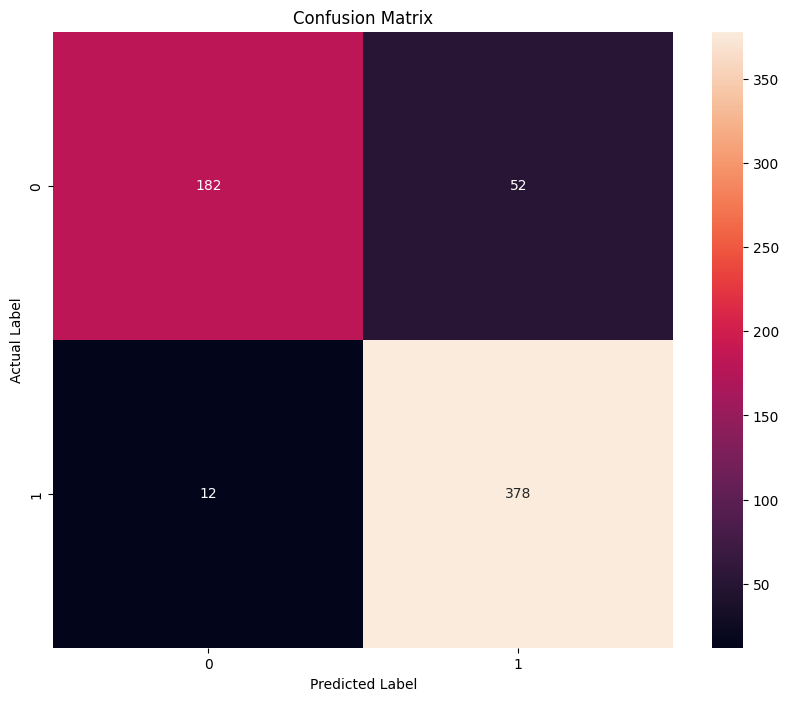

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print(classification_report(y_true, y_pred_classes.astype(int)))
cm = confusion_matrix(y_true, y_pred_classes.astype(int))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [42]:
# Model 3: InceptionV3
from tensorflow.keras.applications import InceptionV3

base_model_inceptionv3 = InceptionV3(weights=local_weights_path_inceptionv3, include_top=False, input_shape=(224, 224, 3))
base_model_inceptionv3.trainable = False

model_inceptionv3 = Sequential([
    base_model_inceptionv3,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# Compile the model
model_inceptionv3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Define callbacks
callbacks = [
    ModelCheckpoint("best_model_inceptionv3.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),  # Increased patience
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

# Train the model
history_inceptionv3 = model_inceptionv3.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=valid_generator.samples // 32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7968 - loss: 3.4009
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model_inceptionv3.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 639ms/step - accuracy: 0.7974 - loss: 3.3761 - val_accuracy: 0.5000 - val_loss: 5.3618 - learning_rate: 5.0000e-04
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.50000


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 5.3618 - learning_rate: 5.0000e-04
Epoch 3/50
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.8849 - loss: 0.2784
Epoch 3: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 563ms/step - accuracy: 0.8849 - loss: 0.2785 - val_accuracy: 0.5000 - val_loss: 10.1914 - learning_rate: 5.0000e-04
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 10.1914 - learning_rate: 5.0000e-04
Epoch 5/50
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.8922 - loss: 0.2734
Epoch 5: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 562ms/step - accuracy: 0.8922 - loss: 0.2732 - val_accuracy: 0.5000 - val_loss: 5.3197 - learning_rate: 5.0000e-04
Epoch 6/50

Epoch 6: val_accuracy did not improve from 

In [43]:
# Evaluate the model on the validation set
eval_result = model_inceptionv3.evaluate(valid_generator, steps=valid_generator.samples // 32)
print(f"Validation Loss: {eval_result[0]}")
print(f"Validation Accuracy: {eval_result[1]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5625 - loss: 3.6242
Validation Loss: 3.624222993850708
Validation Accuracy: 0.5625


In [44]:
# Predict on validation data
valid_generator.reset()
predictions = model_inceptionv3.predict(valid_generator, steps=valid_generator.samples // 32 + 1)
predicted_classes = (predictions > 0.5).astype(int)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [45]:
from sklearn.metrics import classification_report

# True labels
true_classes = valid_generator.classes
class_labels = list(valid_generator.class_indices.keys())

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.33      0.12      0.18         8
   PNEUMONIA       0.46      0.75      0.57         8

    accuracy                           0.44        16
   macro avg       0.40      0.44      0.38        16
weighted avg       0.40      0.44      0.38        16



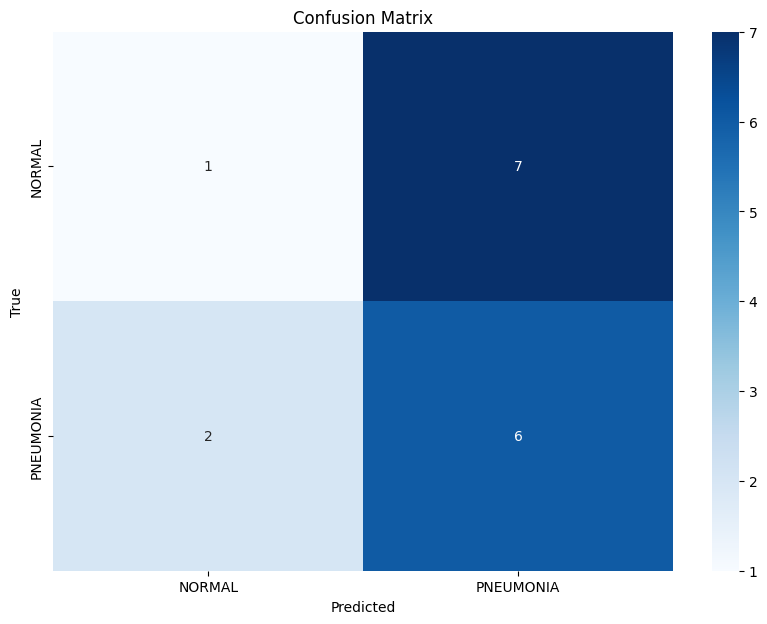

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training set
train_datagen_inception = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation set
valid_datagen_inception = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator_inception = train_datagen_inception.flow_from_directory(
    "/kaggle/input/chest-xray-pneumonia/chest_xray/train",
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

# Validation data generator
valid_generator_inception = valid_datagen_inception.flow_from_directory(
    "/kaggle/input/chest-xray-pneumonia/chest_xray/val",
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

# Test data generator
test_datagen_inception = ImageDataGenerator(rescale=1./255)
test_generator_inception = test_datagen_inception.flow_from_directory(
    "/kaggle/input/chest-xray-pneumonia/chest_xray/test",
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [26]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential

# Load InceptionV3 model with pre-trained weights
local_weights_path = '/kaggle/input/inception-v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model_inceptionv3 = InceptionV3(weights=local_weights_path, include_top=False, input_shape=(299,299,3))

# Freeze the base model
base_model_inceptionv3.trainable = False

model_inceptionv3_1 = Sequential([
    base_model_inceptionv3,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_inceptionv3_1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Define callbacks
callbacks = [
    ModelCheckpoint("best_model_inceptionv3.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

# Train the model
history_inceptionv3_1 = model_inceptionv3_1.fit(
    train_generator_inception,
    epochs=50,
    validation_data=valid_generator_inception,
    steps_per_epoch=train_generator_inception.samples // 32,
    validation_steps=valid_generator_inception.samples // 32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.8345 - loss: 2.9163
Epoch 1: val_accuracy improved from -inf to 0.93750, saving model to best_model_inceptionv3.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 160s 862ms/step - accuracy: 0.8348 - loss: 2.9055 - val_accuracy: 0.9375 - val_loss: 0.2317 - learning_rate: 5.0000e-04
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.93750
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.2317 - learning_rate: 5.0000e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.9163 - loss: 0.2002
Epoch 3: val_accuracy did not improve from 0.93750
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 820ms/step - accuracy: 0.9164 - loss: 0.2002 - val_accuracy: 0.8750 - val_loss: 0.2639 - learning_rate: 5.0000e-04
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.93750
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy:

In [28]:
# Evaluate the model on the validation set
eval_result = model_inceptionv3_1.evaluate(valid_generator_inception, steps=valid_generator_inception.samples // 32)
print(f"Validation Loss: {eval_result[0]}")
print(f"Validation Accuracy: {eval_result[1]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9375 - loss: 0.1698
Validation Loss: 0.16975805163383484
Validation Accuracy: 0.9375


In [77]:
test_loss, test_accuracy = model_inceptionv3_1.evaluate(test_generator_inception)
print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.8521 - loss: 0.3928
Test Accuracy: 0.8910256624221802, Test Loss: 0.288460373878479


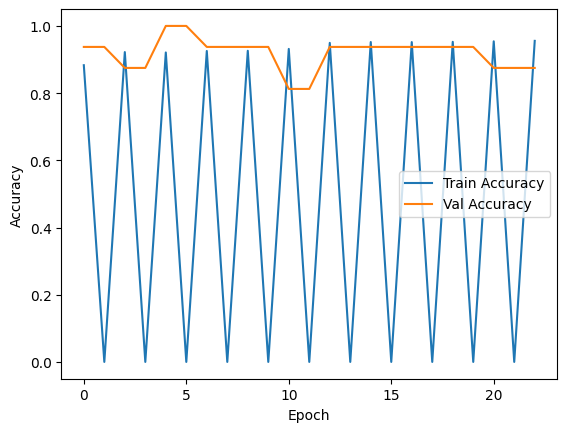

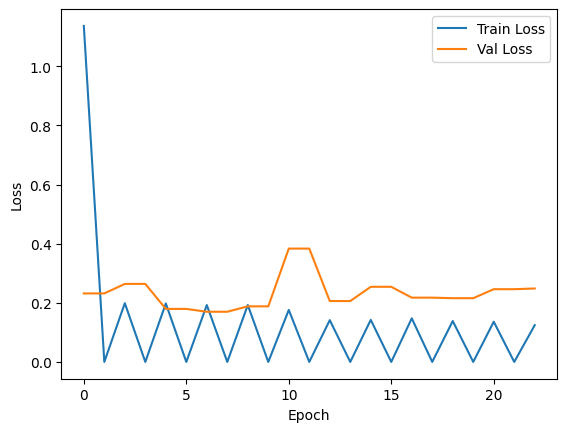

In [29]:
import matplotlib.pyplot as plt

plt.plot(history_inceptionv3_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_inceptionv3_1.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_inceptionv3_1.history['loss'], label='Train Loss')
plt.plot(history_inceptionv3_1.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# Get the test labels and predictions
test_generator_inception.reset()  # Reset the generator to start from the beginning
predictions = model_inceptionv3_1.predict(test_generator_inception, verbose=1)
predicted_classes_inception = (predictions > 0.5).astype("int32")  # Convert probabilities to binary class labels

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 591ms/step


In [31]:
# True labels
true_classes_inception = test_generator_inception.classes

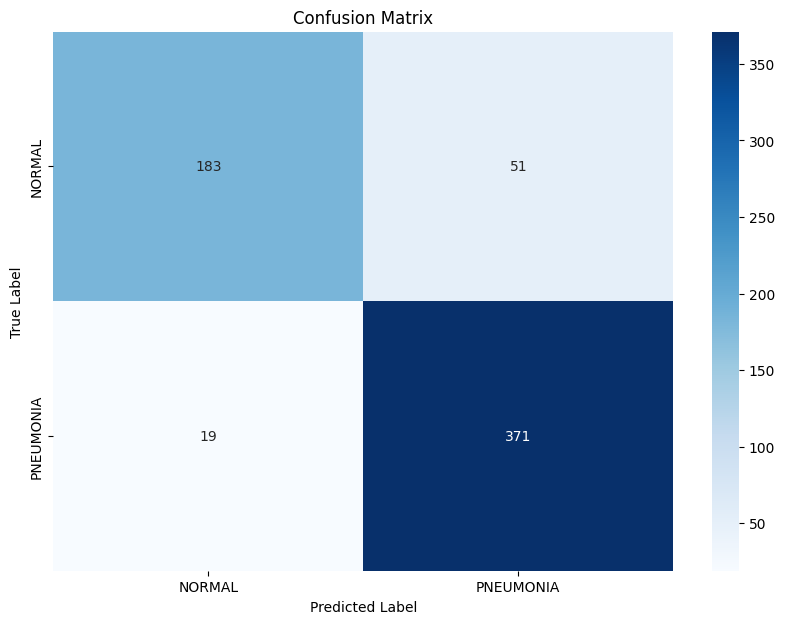

In [32]:
# Compute confusion matrix
cm = confusion_matrix(true_classes_inception, predicted_classes_inception)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator_inception.class_indices.keys(), yticklabels=test_generator_inception.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [33]:
report = classification_report(true_classes_inception, predicted_classes_inception, target_names=class_labels)
print(report)

NameError: name 'class_labels' is not defined